In [30]:
!pip install arviz
!pip install tensorflow tensorflow-probability
!pip install pymc

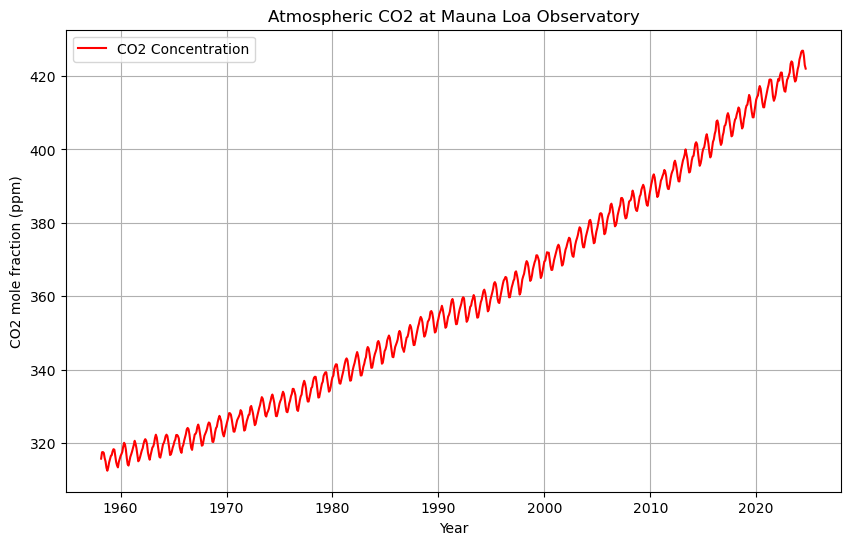

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
import arviz as az
import matplotlib.pyplot as plt


file_path = r"C:\Users\gesua\Documents\Capstone_Project\Capstone\co2_mm_mlo.csv"
co2_data = pd.read_csv(file_path)
co2_data.rename(columns={'year': 'year', 'date_month': 'month'}, inplace=True)
co2_data['date'] = pd.to_datetime(co2_data[['year', 'month']].assign(day=1))

plt.figure(figsize=(10, 6))
plt.plot(co2_data['date'], co2_data['Monthly Average of CO2'], color='red', label='CO2 Concentration')

plt.title('Atmospheric CO2 at Mauna Loa Observatory')
plt.xlabel('Year')
plt.ylabel('CO2 mole fraction (ppm)')
plt.legend()
plt.grid(True)

plt.show()


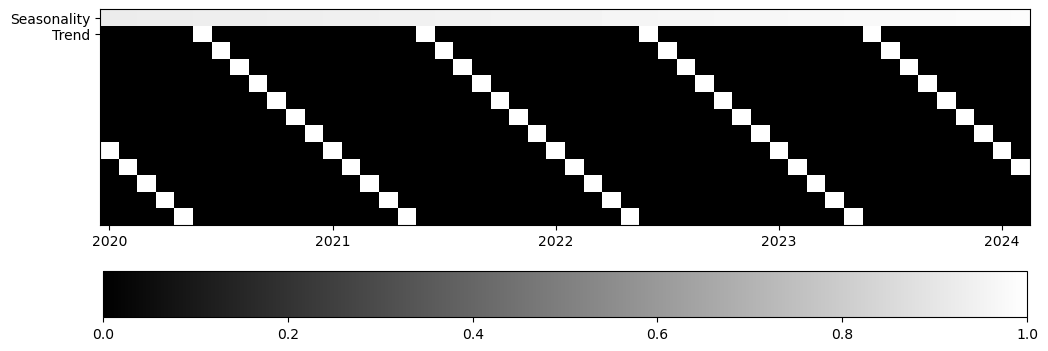

In [52]:
file_path = "C:/Users/gesua/Documents/Capstone_Project/Capstone/co2_mm_mlo.csv"
co2_data = pd.read_csv(file_path)

# Data Cleaning
co2_data.rename(columns=lambda x: x.strip(), inplace=True)
co2_data['month'] = ((co2_data['decimal date'] % 1) * 12 + 1).astype(int)
co2_data['date'] = pd.to_datetime(co2_data[['year', 'month']].assign(day=1))
co2_data.set_index('date', inplace=True)

#Trend and Seasonality 
trend_all = np.linspace(0., 1., len(co2_data))[..., None]
trend_all = trend_all.astype(np.float32)
num_forecast_steps = 12  # Ensure num_forecast_steps is defined
trend = trend_all[:-num_forecast_steps, :]

# Create dummies for seasonality based on month
seasonality_all = pd.get_dummies(co2_data.index.month).values.astype(np.float32)
seasonality = seasonality_all[:-num_forecast_steps, :]

# Visualize
_, ax = plt.subplots(figsize=(12, 4))
X_subset = np.concatenate([trend, seasonality], axis=-1)[-50:]
im = ax.imshow(X_subset.T, aspect='auto', cmap='gray', interpolation='none')
plt.colorbar(im, ax=ax, orientation='horizontal')
ax.set_xticks([0, 12, 24, 36, 48])
ax.set_xticklabels(['2020', '2021', '2022', '2023', '2024'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['Seasonality', 'Trend'])
plt.show()

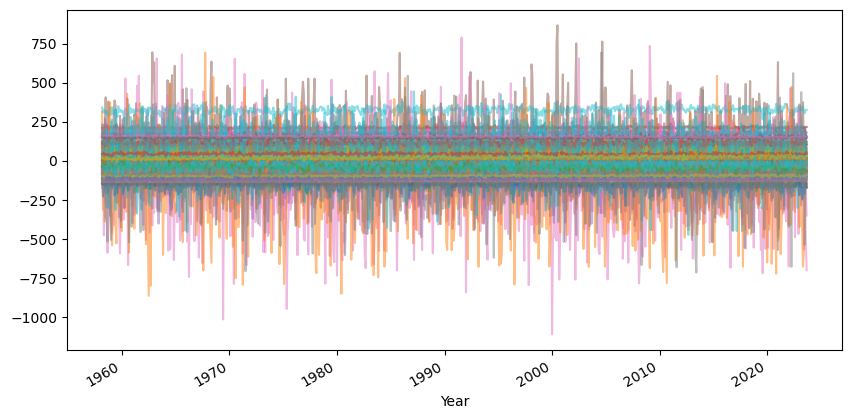

In [33]:
tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

#Defining Time Series Model
@tfd.JointDistributionCoroutine
def ts_regression_model():
    intercept = yield root(tfd.Normal(0., 100., name="intercept"))
    trend_coeff = yield root(tfd.Normal(0., 10., name="trend_coeff"))
    seasonality_coeff = yield root(
        tfd.Sample(tfd.Normal(0., 1.),
                   sample_shape=seasonality.shape[-1],
                   name="seasonality_coeff"))
    noise = yield root(tfd.HalfCauchy(loc=0., scale=5., name="noise_sigma"))

    y_hat = (intercept[..., None] +
             tf.einsum("ij,...->...i", trend, trend_coeff) +
             tf.einsum("ij,...j->...i", seasonality, seasonality_coeff))

    yield tfd.Independent(
        tfd.Normal(y_hat, noise[..., None]),
        reinterpreted_batch_ndims=1,
        name="observed"
    )

model_instance = ts_regression_model

# Draw 100 prior samples
prior_samples = model_instance.sample(100)
prior_predictive_timeseries = prior_samples[-1]  # Use index-based access

# Plot the prior predictive samples
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(co2_data.index[:-num_forecast_steps],
        tf.transpose(prior_predictive_timeseries), alpha=0.5)
ax.set_xlabel("Year")
fig.autofmt_xdate()
plt.show()


This code shows my uninformed prior of intercept ~ Normal(0,100). Meaning that this is a normal distribution of mean 0 and a large standard deviation 100. 
trend coefficient prior: trend_coeff ~ Normal(0,10) meaning that it is centered at 0 with s.d. 10. 
Seasonality prior: Assigned a normal prior with mean 0 and s.d. 1 for each seasonality component.
Noise: half-cauchy distribution, it is constrained to be positive (bc, its s.d.) and allows for the possibility of larger noise levels. 

Prior predictive samples from the simple regression model for the monthly CO2. Each line is one simulated time series, and they were uninformative priors, as they did not stem from the data set originally, but were applied general priors to follow with Gaussian distribution and are pre-defined parameters. 

In [ ]:
tfd = tfp.distributions
sts = tfp.sts

# Prepare Training and Test Data
train_end_date = '2023-12'
co2_training_data = co2_data.loc[:train_end_date, 'Monthly Average of CO2'].values.astype(np.float32)
dates_train = co2_data.index[:len(co2_training_data)]

co2_testing_data = co2_data.loc['2024-01':'2024-09', 'Monthly Average of CO2'].values.astype(np.float32)
dates_test = co2_data.index[len(co2_training_data):len(co2_training_data) + len(co2_testing_data)]

# Defining Bayesian Structural Time Series Model
model = sts.Sum(
    components=[
        sts.LocalLinearTrend(observed_time_series=co2_training_data),
        sts.Seasonal(num_seasons=12, observed_time_series=co2_training_data)
    ],
    observed_time_series=co2_training_data
)

# Variational Surrogate Posterior
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

optimizer = tf.optimizers.Adam(learning_rate=0.1)
tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(co2_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=200
)

# Forecast the Next 9 Months in 2024
forecast_dist = tfp.sts.forecast(
    model=model,
    observed_time_series=co2_training_data,
    parameter_samples=variational_posteriors.sample(50),
    num_steps_forecast=9
)

forecast_mean = forecast_dist.mean().numpy().squeeze()
forecast_index = pd.date_range(dates_train[-1] + pd.DateOffset(months=1), periods=9, freq="M")

#Plotting
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dates_train, co2_training_data, label="Training Data", color="blue")
ax.plot(forecast_index, forecast_mean, label="Forecast for 2024", color="green")
ax.plot(dates_test, co2_testing_data, label="Actual Data (2024)", color="black")

ax.set_xlabel("Year")
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_title("Training Data, Forecast, and Actual Data for 2024")
ax.legend(loc="upper left")

fig.autofmt_xdate()
plt.show()


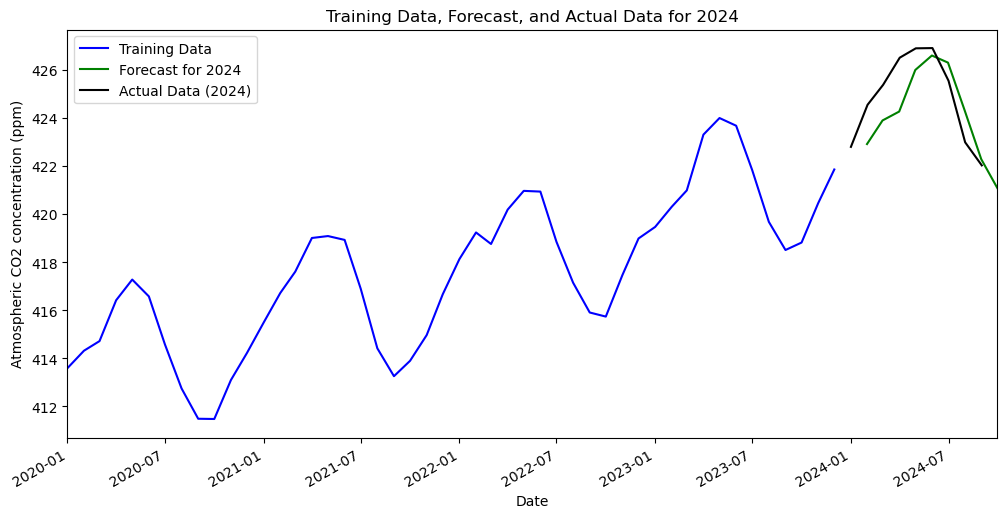

RMSE: 0.7654417753219604
MAPE: 0.1612453255802393%


In [65]:
train_start, train_end = '2020-01', '2023-12'
co2_training_data = co2_data.loc[train_start:train_end, 'Monthly Average of CO2'].values.astype(np.float32)
dates_train = co2_data.loc[train_start:train_end].index

co2_testing_data = co2_data.loc['2024-01':'2024-09', 'Monthly Average of CO2'].values.astype(np.float32)
dates_test = co2_data.loc['2024-01':'2024-09'].index

# Forecast the Next 9 Months
forecast_dist = tfp.sts.forecast(
    model=model,
    observed_time_series=co2_training_data,
    parameter_samples=variational_posteriors.sample(50),
    num_steps_forecast=9
)

forecast_mean = forecast_dist.mean().numpy().squeeze()
forecast_index = pd.date_range(dates_train[-1] + pd.DateOffset(months=1), periods=9, freq="M")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates_train, co2_training_data, label="Training Data", color="blue")
ax.plot(forecast_index, forecast_mean, label="Forecast for 2024", color="green")
ax.plot(dates_test, co2_testing_data, label="Actual Data (2024)", color="black")

ax.set_xlabel("Date")
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_title("Training Data, Forecast, and Actual Data for 2024")
ax.legend(loc="upper left")
ax.set_xlim([pd.to_datetime('2020-01-01'), pd.to_datetime('2024-09-30')])
fig.autofmt_xdate()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(np.mean((forecast_mean - co2_testing_data) ** 2))
mape = np.mean(np.abs((co2_testing_data - forecast_mean) / co2_testing_data)) * 100

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


The code indirectly respects Gaussian priors within the STS framework, but it does not give full control over the exact priors, as in a manually built Bayesian model.
This code graphs the original, graphs the forecast into 2024, and then compares the graphs to the actual 2024 data.